<a id="top"></a>

# Analyze 2D image metrics for 3D StyleGAN (GM)

- [T1 Nifti: pad Cam-CAN images for training](#pad)
- [Export StyleGAN images from Nifti to png](#export)
- [Load StyleGAN images](#load)
- [Statistical functions](#functions)
- [Metrics](#metrics)
  - [Inception Score (IS)](#inception)
  - [Modified Inception Score (m-IS)](#modified_inception)   
  - [Frechet Inception Distance (FID)](#frechet)
  - [Maximum Mean Discrepancy (MMD)](#mmd)
  - [NIQE/BRISQUE](#niqe)
  - [Load/save metrics](#load_save)
- [Deep QA model](#deepqa)
- [PCA](#pca)
 

In [1]:
import os, cv2
import pandas as pd
import numpy as np
import scipy, pickle
from scipy import stats
# import numpy.ma as ma
#import nibabel
# import os, sys, re, pickle, math, PIL
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

# from scipy import stats
# from mri_gan_tools import check_for_batch_folders, load_numpy_images

In [2]:
# This code fixes the error "The kernel appears to have died. It will restart automatically"
# that occurs when using a TF model's predict function
# see: https://moonbooks.org/Articles/How-to-fix-the-error-The-kernel-appears-to-have-died-It-will-restart-automatically-with-Tensorflow-on-Mac-/
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
tf.__version__

'2.7.0'

In [4]:
from pathlib import Path
home = str(Path.home())
print(home)

/Users/matthiastreder


In [5]:
data_dir = os.path.join(home, 'git/MRI-GAN-QA')

modality = 'GM'
print('processing modality', modality)
nifti_dir = os.path.join(data_dir, f'3DStyleGAN/{modality}_repo/results')
image_dir = os.path.join(data_dir, f'3DStyleGAN/{modality}_png')

real_dir =  os.path.join(data_dir, 'experiment/real')

fig_dir  =  os.path.join(data_dir, '3DStyleGAN/figures/')
result_dir =  os.path.join(data_dir, '3DStyleGAN/results/')

n_bootstrap = 10

processing modality GM


In [6]:
# select iteration numbers for analysis
iteration = ('008','016','032','064','128','200', 'real')

 <a id="export"></a>
# Export StyleGAN images from Nifti to png
[back to top](#top)

Takes the three middle slices from the Nifti file and saves them as a single image.
For GM, the image is padded to `432x288` px (to match it with the Cam-CAN experiment images).

In [ ]:
import re 
iteration_dir = sorted([(s, re.findall('iteration(\d+)',s)[0]) for s in os.listdir(nifti_dir) if 'iteration' in s])

# add real dir
iteration_dir = iteration_dir + [('real','real')]

In [ ]:
import nibabel as ni

for it_dir, it in iteration_dir:
    if it != 'real':
        thisdir = os.path.join(nifti_dir, it_dir)
    else:
        if modality == 'GM':
            thisdir = os.path.join(data_dir, 'camcan_data/real')
        else:
            thisdir = os.path.join(data_dir, '3DStyleGAN/T1_64x80x64_nifti')
            
    files = sorted([file for file in os.listdir(thisdir) if file.endswith('.nii.gz')])
        
    print('Found', len(files), 'nifti files for iteration', it)    
    
    for ix, file in enumerate(files):
        # load nifti
        im = ni.load(os.path.join(thisdir, file)).get_fdata().astype(np.float32)
#         if it == 'real': im = im/255.
            
        # extract middle slices and concatenate
        x = im[:,:,96//2]
        x = cv2.rotate(x, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
        x = cv2.copyMakeBorder(x,0,0,8,8, cv2.BORDER_CONSTANT)

        y = im[96//2,...]
        y = cv2.rotate(y, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
        y = cv2.copyMakeBorder(y,8,8,0,0, cv2.BORDER_CONSTANT)

        z = im[:,112//2,:]
        z = cv2.rotate(z, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
        z = cv2.copyMakeBorder(z,8,8,8,8, cv2.BORDER_CONSTANT)

        I = np.concatenate((y,x,z), axis=1)
        if modality == 'GM':
            # bring to same size as Psytoolkit images
            I = cv2.copyMakeBorder(I,88,88,48,48, cv2.BORDER_CONSTANT) 
        
        if it == 'real': I *= 255
                
        if not os.path.exists(os.path.join(image_dir, it)): os.mkdir(os.path.join(image_dir, it))
        cv2.imwrite(os.path.join(image_dir, it, f'{it}_im_{ix}.png'), I)
#         cv2.imwrite(os.path.join(image_dir, it, f'{file.split(".")[0]}.png'), I)
        
print(I.shape)
plt.imshow(I, cmap='gray')

 <a id="load"></a>
# Load StyleGAN images
[back to top](#top)

In [7]:
# Load StyleGAN images
assert modality == 'GM', 'only run this cell when modality=GM' 

images = {}
max_im = 100

for it in iteration:
    path = os.path.join(image_dir, it)
    files = [file for file in os.listdir(path) if file.endswith('.png')][:max_im]
    print('Found', len(files), 'png files for iteration', it)    

    tmp = np.zeros((len(files), 135, 355, 3))
    for ix, file in enumerate(files):
        im = cv2.imread(os.path.join(path, file))
        im = im[75:210,34:389]  # cut away the empty area around the MRI 
        tmp[ix, :, :, :] = im
    tmp = tmp / 255.
    images[it] = tmp

del tmp

# # Load real images
# df_reals = pd.read_csv(os.path.join(data_dir, 'experiment/Psytoolkit/main_experiment_table.txt'), sep=' ', header=None, names=['image','button','batch']).sort_values(by='batch').reset_index()
# df_reals = df_reals[df_reals['image'].str.match('real')] # select real images only

# path = os.path.join(image_dir, 'real')
# print('Found', df_reals.shape[0], 'png files for real')

# tmp = np.zeros((df_reals.shape[0], 135, 355, 3))
# for ix in range(df_reals.shape[0]):
#     im = cv2.imread(os.path.join(path, df_reals.iloc[ix,1] + '.png'))
#     im = im[75:210,34:389]  # cut away the empty area around the MRI 
#     tmp[ix, :, :, :] = im
# tmp = tmp / 255.
# images['real'] = tmp

# del tmp

Found 100 png files for iteration 008
Found 100 png files for iteration 016
Found 100 png files for iteration 032
Found 100 png files for iteration 064
Found 100 png files for iteration 128
Found 100 png files for iteration 200
Found 100 png files for iteration real


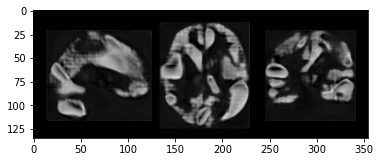

In [8]:
plt.imshow(images['032'][0,...])
# plt.imshow(images['real'][0,...])

In [9]:
# for Inception Score and VGG features, images need to be padded to (299,299)
images_tf = {key:tf.image.resize_with_pad(ims, target_height=299, target_width=299) for key,ims in images.items()}

# scale to the range [-1, 1]
for key in images_tf.keys():
#     images_tf[key] /= 127.5
#     images_tf[key] -= 1
    images_tf[key] *= 2
    images_tf[key] -= 1

2022-02-06 17:34:54.280782: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# create 2D mask so we can extract brain pixels
av = images_tf['real'][...,0].numpy().mean(axis=0)
mask_2d = av>-1+10e-10

 <a id="functions"></a>
# Statistical functions
[back to top](#top)


In [16]:
def bootstrap1(ims, fun, n_bootstrap = 100):
    '''Applies function `fun` `n_bootstrap` times 
    on bootstrapped versions of ims. Returns 
    a list of results.
    
    Useful for getting bootstrapped error bars for metrics.
    '''
    bootstraps = []
    n = ims.shape[0]
    for _ in range(n_bootstrap): 
        ix = np.random.choice(n, replace=True, size=n)
        bootstraps.append(fun(ims[ix,...]))
    return bootstraps

In [17]:
def bootstrap2(ims1, ims2, fun, n_bootstrap = 100):
    '''Like bootstrap1 but assumes that two sets of images (e.g. target and reference image)
       are used as input to `fun`.
    '''
    bootstraps = []
    n1, n2 = ims1.shape[0], ims2.shape[0]
    for _ in range(n_bootstrap): 
        ix1 = np.random.choice(n1, replace=True, size=n1)
        ix2 = np.random.choice(n2, replace=True, size=n2)
        bootstraps.append(fun(ims1[ix1,...], ims2[ix2,...]))
    return bootstraps
    

In [18]:
def wilcoxon_ranksum(df, col, stat=None, appendix = '', do_print=False, do_remove=True):
    '''Performs Wilcoxon ranksum tests on df[col] for all batches
    Args:
        appendix: string added to the name of the metric
        do_remove: if True and `col` is already present in stat, it is removed first
    '''
    if do_print: print(col)
    if 'real' in list(df.iteration.unique()): 
        stat_iterations = batches + ['real']
    else:
        stat_iterations = batches

    if (stat is not None) and (col in list(stat['metric'].unique()) and do_remove):
        print(col, 'is already present, replacing')
        stat = stat[stat.metric != col]
        
    # compare iterations
    for ix in range(len(stat_iterations)-1):
        df1 = df[df.iteration == stat_iterations[ix]]
        df2 = df[df.iteration == stat_iterations[ix+1]]
        s = stats.ranksums(df1[col], df2[col])
        if do_print: print(f'Batch {stat_iterations[ix]} vs {stat_iterations[ix+1]}:', s)
        if stat is not None:
            stat = stat.append(pd.Series({'metric':col + appendix, 'batch':stat_iterations[ix], \
                                   'batch2':stat_iterations[ix+1],\
                                 'p':s.pvalue, 'z':s.statistic}, name = col), ignore_index=True)
    return stat

In [19]:
def ordinal_regression(target, predictors):
    '''Performs ordinal regression using a Logit model'''
    from statsmodels.miscmodels.ordinal_model import OrderedModel
    fitted = OrderedModel(target, predictors, distr='probit').fit()
    return fitted

In [20]:
def convert_batch_to_ordinal(df):
    '''Converts the `batch` column to ordered categorical type'''
    categories = [344, 1055,  7954, 24440, 60000]
    if 'real' in df['batch'].unique(): categories.append('real')
    cat_type = pd.api.types.CategoricalDtype(\
                                categories=categories,\
                                ordered=True)
    df['batch'] = df['batch'].astype(cat_type)

In [21]:
def linear_regression(y, x):
    # regress y on log x
    import statsmodels.api as sm
    x = np.log(x.astype('str').astype('float'))
    xi = np.stack((x, np.ones(x.shape)), axis=1) # add intercept
    fit = sm.OLS(y, xi).fit()
    print(fit.summary2())

In [22]:
# empty dataframe that will be filled with stats
stat = pd.DataFrame({'metric':[], 'batch':[], 'batch2':[],'p':[], 'z':[]})
stat

,metric,batch,batch2,p,z


In [23]:
n_bootstrap = 100

----

<a id="metrics"></a>
# Metrics

----

<a id="inception"></a>
# Inception score
[back to top](#top)

In [24]:
def calculate_inception_score(pred_softmax, do_average=True, do_exp=True, eps=1E-16):
    '''
    Args:
        pred_softmax - softmax predictions
    '''
    p_yx = pred_softmax
    
    # calculate p(y)
    p_y = np.expand_dims(p_yx.mean(axis=0), axis=0)
    
    # kl divergence for each image
    kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
    
    # sum over classes
    sum_kl_d = kl_d.sum(axis=1)
  
    if do_average: sum_kl_d = sum_kl_d.mean()
    
    is_score = np.exp(sum_kl_d) if do_exp else sum_kl_d
    return is_score

In [25]:
# load inception model
inception_model = tf.keras.applications.InceptionV3(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000
#     classifier_activation='softmax'
)

In [26]:
# calculate predictions for all images
pred_softmax = {key:inception_model.predict(ims, batch_size=16) for key, ims in images_tf.items()}
pred_softmax['real'].shape

(100, 1000)

In [27]:
df_is = []

for it in iteration:
    print('processing iteration', it)
#     IS = bootstrap1(pred_softmax[it], calculate_inception_score, n_bootstrap=n_bootstrap)
#     tmp = pd.DataFrame({'bootstrap':range(n_bootstrap), 'IS':IS, 'batch':b})
    IS = calculate_inception_score(pred_softmax[it], do_average=False)
    tmp = pd.DataFrame({'IS':IS, 'iteration':it})
    df_is.append(tmp)


df_is = pd.concat(df_is, axis=0)
df_is['iteration'] = df_is['iteration'].astype('category')
df_is.dtypes

processing iteration 008
processing iteration 016
processing iteration 032
processing iteration 064
processing iteration 128
processing iteration 200
processing iteration real


IS            float32
iteration    category
dtype: object

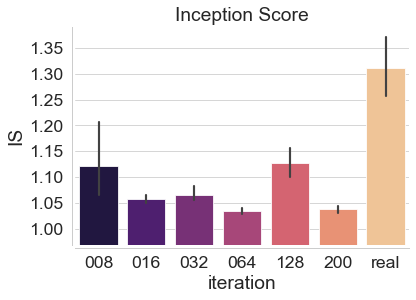

In [29]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='iteration', y='IS', palette="magma", data=df_is)
#     plt.ylabel('IS')
    plt.title('Inception Score')
    if modality=='T1': plt.ylim([.93, 1.44])
    if modality=='GM': plt.ylim([.97, 1.39])
    sns.despine(ax=ax, offset=3)
    plt.savefig(fig_dir + f'{modality}_metrics_IS.png', dpi=200, bbox_inches='tight')

In [35]:
tmp = df_is[df_is.iteration != 'real']
linear_regression(tmp['IS'], tmp['iteration'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.002    
Dependent Variable: IS               AIC:                -370.1713
Date:               2022-02-05 11:37 BIC:                -361.3774
No. Observations:   600              Log-Likelihood:     187.09   
Df Model:           1                F-statistic:        2.434    
Df Residuals:       598              Prob (F-statistic): 0.119    
R-squared:          0.004            Scale:              0.031488 
--------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
--------------------------------------------------------------------
x1          -0.0100     0.0064   -1.5601   0.1193   -0.0227   0.0026
const        1.1121     0.0253   43.9090   0.0000    1.0623   1.1618
------------------------------------------------------------------
Omnibus:            1212.981     Durbin-Watson:        1.961      
Pro

----

<a id="modified_inception"></a>
# Modified Inception score
[back to top](#top)

In [36]:
def calculate_modified_inception_score(pred_softmax, do_exp=True, eps=1E-16):
    p_yx = pred_softmax
    
    # predicted classes
    class_labels = pred_softmax.argmax(axis=1)

    # calculate modified score per class
    kl_d = []
#     print('classes:', np.unique(class_labels))
    for c in np.unique(class_labels): # -- per class -- 
        p_yx_c = p_yx[class_labels == c,:]
#         print('class c:', p_yx_c.shape)
        kls = []
        for ix1 in range(p_yx_c.shape[0]):
            kl2 = []
            for ix2 in range(p_yx_c.shape[0]):
                if ix1==ix2: continue
                kl = p_yx_c[ix1,:] * ( np.log(p_yx_c[ix1,:] + eps) - np.log(p_yx_c[ix2,:] + eps) )
                kl2.append(kl.sum())
            if len(kl2)>0: kls.append(sum(kl2)/len(kl2))
    
        # append within-class mean
        if len(kls)>1: kl_d.append(sum(kls)/len(kls))

#     print('kl_d:', len(kl_d))
#     kl_d = sum(kl_d)/len(kl_d)
    kl_d = sum(kl_d)
    
    mis_score = np.exp(kl_d) if do_exp else kl_d
    return mis_score #, class_labels

In [37]:
# load inception model
inception_model = tf.keras.applications.InceptionV3(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000
#     classifier_activation='softmax'
)

In [38]:
# calculate predictions for all images
pred_softmax = {key:inception_model.predict(ims, batch_size=16) for key, ims in images_tf.items()}

In [39]:
df_mis = []

for it in iteration:
    print('processing iteration', it)
    # find start and end index of images corresponding to this batch
    IS = bootstrap1(pred_softmax[it], calculate_modified_inception_score, n_bootstrap)
    tmp = pd.DataFrame({'bootstrap':range(n_bootstrap), 'MIS':IS, 'iteration':it})
#     IS = calculate_modified_inception_score(pred_softmax[it])
#     tmp = pd.DataFrame({'MIS':IS, 'iteration':it})
    df_mis.append(tmp)
    
df_mis = pd.concat(df_mis, axis=0)

processing iteration 008
processing iteration 016
processing iteration 032
processing iteration 064
processing iteration 128
processing iteration 200
processing iteration real


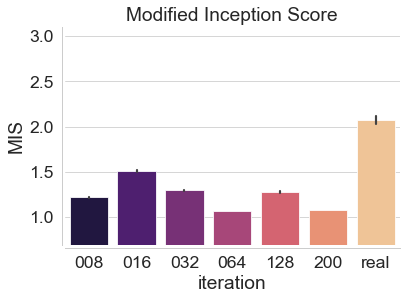

In [40]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='iteration', y='MIS', palette="magma", data=df_mis)
    plt.ylim((0.7, 3.1)) # T1
    plt.title('Modified Inception Score')
    sns.despine(ax=ax, offset=3)
    plt.savefig(fig_dir + f'{modality}_metrics_MIS.png', dpi=200, bbox_inches='tight')
    
# print('Batch 60000 vs Real:', stats.ranksums(df_mis[df_mis.batch == 60000]['MIS'],df_mis[df_mis.batch == 'real']['MIS']))

In [42]:
tmp = df_mis[df_mis.iteration != 'real']
linear_regression(tmp['MIS'], tmp['iteration'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.251    
Dependent Variable: MIS              AIC:                -715.8403
Date:               2022-02-05 11:50 BIC:                -707.0465
No. Observations:   600              Log-Likelihood:     359.92   
Df Model:           1                F-statistic:        201.4    
Df Residuals:       598              Prob (F-statistic): 1.30e-39 
R-squared:          0.252            Scale:              0.017699 
--------------------------------------------------------------------
           Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
--------------------------------------------------------------------
x1        -0.0685     0.0048   -14.1923   0.0000   -0.0779   -0.0590
const      1.5004     0.0190    79.0166   0.0000    1.4631    1.5377
------------------------------------------------------------------
Omnibus:              209.652       Durbin-Watson:          0.196 
Pro

---


<a id="frechet"></a>
# Frechet Inception Distance
[back to top](#top)

based on https://github.com/bioinf-jku/TTUR/blob/master/fid.py


In [45]:
# based on: https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    
    # calculate sqrt of product between cov
#     print('calculate sqrt')
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
#     print('finished sqrt')
    
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
        
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [46]:
# load inception model without last layer
inception_model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=None, pooling='avg', classes=1000
)

In [47]:
# calculate predictions for all images
pred = {key:inception_model.predict(ims, batch_size=16) for key, ims in images_tf.items()}

In [48]:
df_fid = []
act1 = pred['real']

for it in iteration[:-1]:
    print('processing iteration', it)
    # find start and end index of images corresponding to this batch
    act2 = pred[it]
    fid = bootstrap2(act1, act2, calculate_fid, n_bootstrap)
    tmp = pd.DataFrame({'bootstrap':range(n_bootstrap), 'FID':fid})
    tmp['iteration'] = it
    df_fid.append(tmp)
    
df_fid = pd.concat(df_fid, axis=0)

processing iteration 008
processing iteration 016
processing iteration 032
processing iteration 064
processing iteration 128
processing iteration 200


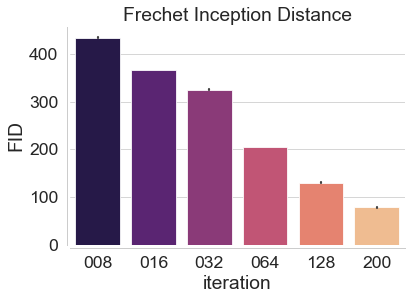

In [49]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='iteration', y='FID', palette="magma", data=df_fid)
#     plt.ylim([20, 160]); ax.set_yticks(range(20, 160, 20))
    plt.title('Frechet Inception Distance')
    sns.despine(ax=ax, offset=3)
    plt.savefig(fig_dir + f'{modality}_metrics_FID.png', dpi=200, bbox_inches='tight')

In [52]:
tmp = df_fid[df_fid.iteration != 'real']
linear_regression(tmp['FID'], tmp['iteration'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.985    
Dependent Variable: FID              AIC:                5016.7954
Date:               2022-02-05 16:26 BIC:                5025.5893
No. Observations:   600              Log-Likelihood:     -2506.4  
Df Model:           1                F-statistic:        3.910e+04
Df Residuals:       598              Prob (F-statistic): 0.00     
R-squared:          0.985            Scale:              249.67   
-------------------------------------------------------------------
         Coef.    Std.Err.      t      P>|t|     [0.025     0.975] 
-------------------------------------------------------------------
x1     -113.3157    0.5730  -197.7462  0.0000  -114.4411  -112.1903
const   683.7817    2.2552   303.1974  0.0000   679.3526   688.2109
------------------------------------------------------------------
Omnibus:             141.859       Durbin-Watson:          0.075  
Prob(Omn

---


<a id="mmd"></a>
# Maximum Mean Discrepancy (MMD)
[back to top](#top)

In [53]:
def calculate_mmd(im1, im2):
    '''
    im1, im2: (n_samples, n_features) matrices of images
    '''
    from sklearn.metrics.pairwise import rbf_kernel
    n1 = im1.shape[0]
    mmd = rbf_kernel(im1,im1).sum() + rbf_kernel(im2,im2).sum() - 2*rbf_kernel(im1,im2).sum()
    
    return mmd

In [54]:
# load inception model without last layer
inception_model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=None, pooling='avg', classes=1000
)

In [55]:
# calculate VGG predictions for all images
pred = {key:inception_model.predict(ims, batch_size=16) for key, ims in images_tf.items()}

In [56]:
# # alternatively, extract pixels directly using a brain mask
# im_pixels = np.zeros((n_images, mask_2d.sum()))

# for n in range(n_images):
#     im_pixels[n, :] = images_tf.numpy()[n, :, :, 0][mask_2d]

In [57]:
real_pred = pred['real']
df_mmd = []

for it in iteration[:-1]:
    print('processing iteration', it)
    # find start and end index of images corresponding to this batch
    gan_pred = pred[it]
    mmd_pred = bootstrap2(real_pred, gan_pred, calculate_mmd, n_bootstrap=n_bootstrap)
    tmp  = pd.DataFrame({'bootstrap':range(n_bootstrap), 'MMD':mmd_pred, 'iteration':it, 'features':'VGG'})
    df_mmd.append(tmp)
#     gan_pixels = im_pixels[gan_ix[0]:gan_ix[1]+1,:]
#     mmd_pixels = bootstrap2(im_pixels[real_ix[0]:real_ix[1]+1,:], gan_pixels, calculate_mmd, n_bootstrap=n_bootstrap)
#     tmp2 = pd.DataFrame({'bootstrap':range(n_bootstrap), 'MMD':mmd_pixels, 'batch':b, 'features':'pixels'})
#     df_mmd.extend([tmp,tmp2])
    
df_mmd = pd.concat(df_mmd, axis=0)

processing iteration 008
processing iteration 016
processing iteration 032
processing iteration 064
processing iteration 128
processing iteration 200


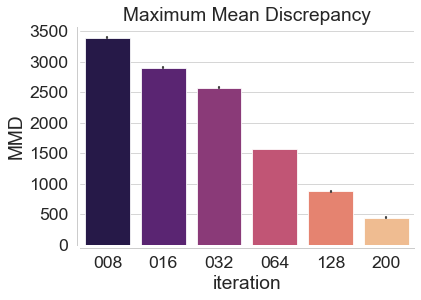

In [58]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='iteration', y='MMD', palette="magma", data=df_mmd)
#     ax = sns.barplot(x='batch', y='MMD', palette="magma", hue='features', data=df_mmd)
    plt.title('Maximum Mean Discrepancy')
    sns.despine(ax=ax, offset=3)
#     ax.set_yticks([2200, 2300, 2400, 2500, 2600])
#     plt.ylim([2250, 2550])
    plt.savefig(fig_dir + f'{modality}_metrics_MMD.png', dpi=200, bbox_inches='tight')

In [60]:
tmp = df_mmd[df_mmd.iteration != 'real']
linear_regression(tmp['MMD'], tmp['iteration'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.979    
Dependent Variable: MMD              AIC:                7766.6550
Date:               2022-02-05 16:29 BIC:                7775.4489
No. Observations:   600              Log-Likelihood:     -3881.3  
Df Model:           1                F-statistic:        2.789e+04
Df Residuals:       598              Prob (F-statistic): 0.00     
R-squared:          0.979            Scale:              24422.   
-------------------------------------------------------------------
         Coef.    Std.Err.      t      P>|t|     [0.025     0.975] 
-------------------------------------------------------------------
x1     -946.4768    5.6675  -167.0016  0.0000  -957.6073  -935.3462
const  5525.9237   22.3049   247.7453  0.0000  5482.1184  5569.7291
------------------------------------------------------------------
Omnibus:             109.957       Durbin-Watson:          0.061  
Prob(Omn

---

<a id="load_save"></a>
# Load/save metrics
[back to top](#top)

In [ ]:
# Load data
with open(result_dir + f'{modality}_analyze_gan_2D_all_metrics.pickle', 'rb') as f:
    (df_is, df_mis, df_fid, df_mmd, stat) = pickle.load(f)

In [61]:
# Save data
with open(result_dir + f'{modality}_analyze_gan_2D_all_metrics.pickle', 'wb') as f:
    pickle.dump((df_is, df_mis, df_fid, df_mmd, stat), f, protocol=pickle.HIGHEST_PROTOCOL)

---

<a id="niqe"></a>
# NIQE/BRISQUE
[back to top](#top)

Load results created with Matlab script `3DStyleGAN/analyze_2D_image_NIQE_BRISQUE.m`

In [63]:
nb = pd.read_csv(result_dir + f'analyze_2D_image_NIQE_BRISQUE_{modality}.csv')
nb.head()

,iteration,niqe,brisque,niqe-mri,brisque-mri (transfer)
0,008,6.461453,51.655718,11.171592,2.912952
1,008,6.556684,51.515238,10.883709,2.912952
2,008,6.113325,51.517355,10.154263,2.912952
3,008,6.220090,51.363671,8.785431,2.912952
4,008,6.510200,51.895047,11.854480,2.912952


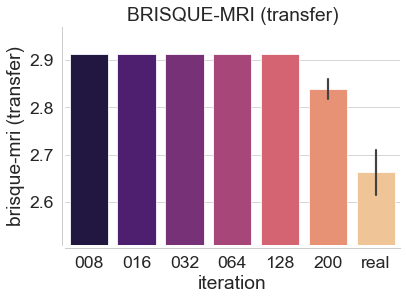

In [64]:
m = 'niqe'
# m = 'brisque'
# m = 'niqe-mri'
m = 'brisque-mri (transfer)'
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='iteration', y=m, palette="magma", data=nb)
    plt.title(m.upper())
    plt.title('BRISQUE-MRI (transfer)')
#     plt.ylabel('MOS')
    sns.despine(ax=ax, offset=3)
#     ax.set_yticks([2200, 2300, 2400, 2500, 2600])
    if modality=='T1':
        if m=='niqe': plt.ylim([4.1, 15])
    elif modality=='GM':
        if m=='niqe': plt.ylim([5.1, 9.9])
        if m=='brisque-mri (transfer)': plt.ylim([2.51, 2.97])

    plt.savefig(fig_dir + f'{modality}_metrics_{m}.png', dpi=200, bbox_inches='tight')


In [68]:
tmp = nb[nb.iteration != 'real']

# linear regression
for m in ('niqe', 'niqe-mri', 'brisque', 'brisque-mri (transfer)'):
    print('---', m, '---')
    linear_regression(tmp[m], tmp['iteration'])


--- niqe ---
                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.119    
Dependent Variable: niqe             AIC:                1383.1065
Date:               2022-02-05 16:33 BIC:                1391.9004
No. Observations:   600              Log-Likelihood:     -689.55  
Df Model:           1                F-statistic:        81.80    
Df Residuals:       598              Prob (F-statistic): 2.09e-18 
R-squared:          0.120            Scale:              0.58507  
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
x1         -0.2509     0.0277   -9.0444   0.0000   -0.3054   -0.1964
const       7.3651     0.1092   67.4621   0.0000    7.1506    7.5795
------------------------------------------------------------------
Omnibus:               30.671       Durbin-Watson:       

<a id="deepqa"></a>
# Deep QA model
[back to top](#top)

In [114]:
df_qa = pd.read_csv(result_dir + 'DeepQA_ratings_StyleGAN_GM.csv')
df_qa = df_qa[df_qa.iteration.map(lambda x: x in iteration)]  # keep only target iterations
df_qa.iteration = pd.Categorical(df_qa.iteration)

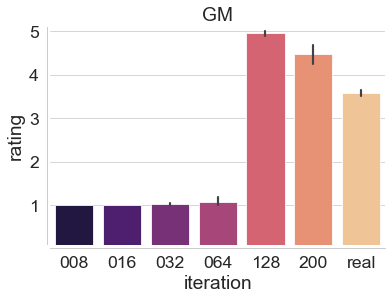

In [115]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
#     plt.figure(figsize=(11,4))

#     ax = sns.lineplot(x='iteration', y='rating', palette="magma", data=df_qa)
    ax = sns.barplot(x='iteration', y='rating', palette="magma", data=df_qa)
#     ax.tick_params(axis='x', rotation=45)
    plt.ylim(0.1, 5.1)
    plt.title(modality)
    sns.despine(ax=ax, offset=3)
    plt.savefig(fig_dir + f'{modality}_DeepQA_rating.png', dpi=200, bbox_inches='tight')

<a id="pca"></a>
# PCA
[back to top](#top)

In [11]:
from sklearn.decomposition import PCA
keys = list(images.keys())

In [16]:
total_variance = []
pc1 = []  # relative variance explained by PC1
pc2 = []  # relative variance explained by PC2
pc3 = []  # relative variance explained by PC2
for key in keys:
    im = images[key][...,0].reshape((images[key].shape[0],-1))
    pca = PCA().fit(im)
    total_variance.append(sum(pca.explained_variance_))
    pc1.append(pca.explained_variance_ratio_[0])
    pc2.append(pca.explained_variance_ratio_[1])
    pc3.append(pca.explained_variance_ratio_[2])

In [17]:
df_pca = pd.DataFrame({'iteration':keys, 'total_variance':total_variance, 'pc1':pc1, 'pc2':pc2, 'pc3':pc3})
df_pca['pc123'] = df_pca.pc1 + df_pca.pc2 + df_pca.pc3

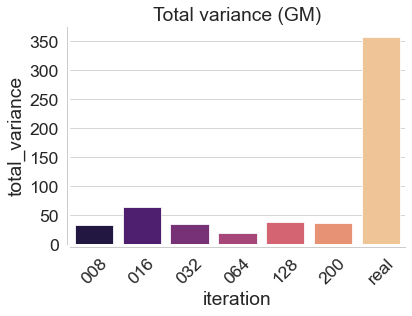

In [18]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
#     plt.figure(figsize=(11,4))

    ax = sns.barplot(x='iteration', y='total_variance', palette="magma", data=df_pca)
    ax.tick_params(axis='x', rotation=45)
    plt.title(f'Total variance ({modality})')
    sns.despine(ax=ax, offset=3)
    plt.savefig(fig_dir + f'PCA_{modality}_pca_total_variance.png', dpi=200, bbox_inches='tight')

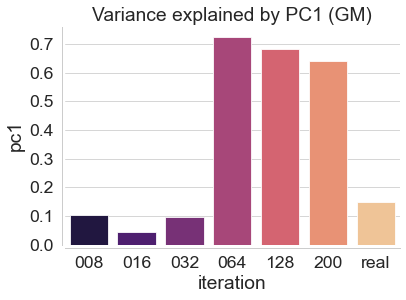

In [19]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
#     plt.figure(figsize=(11,4))

    ax = sns.barplot(x='iteration', y='pc1', palette="magma", data=df_pca)
    plt.title(f'Variance explained by PC1 ({modality})')
    sns.despine(ax=ax, offset=3)
    plt.savefig(fig_dir + f'PCA_{modality}_pc1.png', dpi=200, bbox_inches='tight')

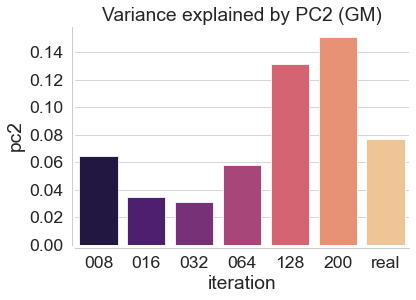

In [20]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
#     plt.figure(figsize=(11,4))

    ax = sns.barplot(x='iteration', y='pc2', palette="magma", data=df_pca)
    plt.title(f'Variance explained by PC2 ({modality})')
    sns.despine(ax=ax, offset=3)
    plt.savefig(fig_dir + f'PCA_{modality}_pc2.png', dpi=200, bbox_inches='tight')

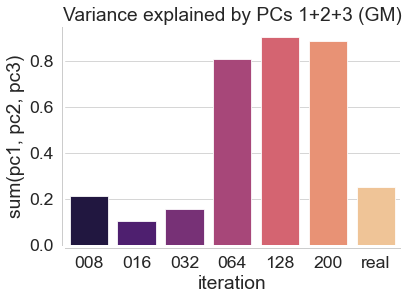

In [21]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
#     plt.figure(figsize=(11,4))
    ax = sns.barplot(x='iteration', y='pc123', palette="magma", data=df_pca)
    plt.ylabel('sum(pc1, pc2, pc3)')
    plt.title(f'Variance explained by PCs 1+2+3 ({modality})')
    sns.despine(ax=ax, offset=3)
    plt.savefig(fig_dir + f'PCA_{modality}_pc123.png', dpi=200, bbox_inches='tight')

### Plot eigenvalue spectrum

In [24]:
dfs = []
for key in keys:
    im = images[key][...,0].reshape((100,-1))
    pca = PCA().fit(im)
    dfs.append(pd.DataFrame({'iteration':key, 'EV_number':range(len(pca.explained_variance_ratio_)), 'EV':pca.explained_variance_ratio_}))

df_ev = pd.concat(dfs, axis=0).reset_index()

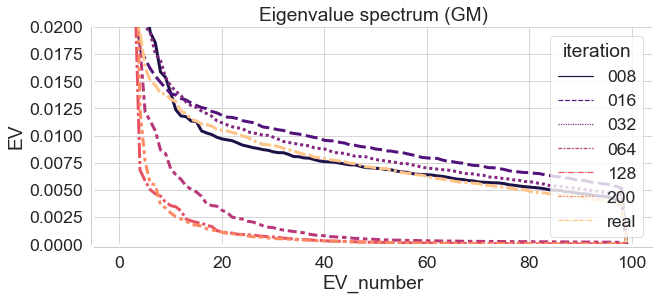

In [25]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    plt.figure(figsize=(10,4))
    plt.title(f'Eigenvalue spectrum ({modality})')
    ax = sns.lineplot(x='EV_number', y='EV', hue='iteration',style='iteration', palette="magma", 
                      linewidth=3,
                      data=df_ev)
#     ax.tick_params(axis='x', rotation=45)
#     plt.title(modality)
    sns.despine(ax=ax, offset=3)
    plt.ylim(0,0.02)
    plt.savefig(fig_dir + f'PCA_{modality}_normalized_EV_spectrum.png', dpi=200, bbox_inches='tight')